# Multi-materials simulation

In this demo, we will perform a multi-materials simulation. This will be our problem case.
The following FESTIM features will be used:
- Multi-materials
- Meshing:
    - mesh from vertices
- Boundary conditions:
    - Recombination flux
- Exports:
    - txt exports
    - Flux computations
    - Integrations over volumes for inventories calculation
- Plotting with matplotlib

## 1. Problem definition
The domain is a composite slab W/Cu/W as described below:
 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104934903-e10d7500-59aa-11eb-9296-17de99140701.jpg" width="40%">
</p>

- $\Omega = [0;1.5\times10^{-7}]$
- $\Omega_1 = [0;5\times10^{-8}]$ (W left)
- $\Omega_2 = [5\times10^{-8};1\times10^{-7}] $ (Cu)
- $\Omega_3 = [1\times10^{-7};1.5\times10^{-7}]$ (W right)
- $D(T) = \begin{cases}
    4.1\times 10^{-7} \exp{(-0.39/k_B T)}, & \text{on } \Omega_1 \text{ and } \Omega_3\\
    1.5\times 10^{-7} \exp{(-0.15/k_B T)}, & \text{on } \Omega_2
    \end{cases}$
- Trap 1 in $\Omega_2$ and $\Omega_3$:
    - Density: $n_1 = 1.3\times 10^{-3} \text{ at.fr.}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8.4\times 10^{12} \exp{(-1.2/k_B T)} \text{ s}^{-1}$
- Trap 2 in $\Omega_2$:
    - Density: $n_2 = 5\times10^{-5} \text{ at.fr.}$
    - Trapping rate: $k(T) = 6 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8\times10^{13} \exp{(-1.0/k_B T)} \text{ s}^{-1}$


A Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and a recombination flux is imposed on $\Gamma_\mathrm{right}$.

- $c_\mathrm{m} = 10^{20} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $-D \nabla c_\mathrm{m} \cdot n = -K c_\mathrm{m}^2 \quad \text{on }\Gamma_\mathrm{right}$
with $K = 2.9\times 10^{-14} \exp{(-1.92/k_B T)} \; \mathrm{m}^4 \mathrm{s}^{-1}$

## 2. Implementation
The first step is to create an empty parameters dictionnary

In [1]:
parameters = {}

### 2.1 Materials.

`"borders"` represents the boundaries of the 1D domain in $\text{m}$.

`"E_D"` is the energy barrier for diffusion expressed in $\text{eV}$.

`"D_0"` is the pre-exponential factor of the Arhenius' law for the diffusion coefficient expressed in $\text{m}^{2}\text{s}^{-1}$.

Finally, `"id"` is the id of the material subdomain. This will be needed later on.

In [2]:
tungsten_left = {
    "borders": [0, 0.5e-7],
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 1
}
copper = {
    "borders": [0.5e-7, 1e-7],
    "E_D": 0.15,
    "D_0": 1.5e-7,
    "id": 2
}
tungsten_right = {
    "borders": [1e-7, 1.5e-7],
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 3
}
parameters["materials"] = [tungsten_left, copper, tungsten_right]

### 2.2 Meshing
Now it's time to create a mesh for our simulation. One way of creating a 1D mesh in FESTIM is to directly provide the mesh coordinates (vertices). In this case, we want 200 nodes in the left sub-domain, 100 nodes in the middle one and finally 200 cells in right sub-domain.

In [3]:
import numpy as np

vertices = np.unique(np.concatenate(
        [np.linspace(0, 0.5e-7, num=200),
        np.linspace(0.5e-7, 1e-7, num=100),
        np.linspace(1e-7, 1.5e-7, num=200)]))

parameters["mesh_parameters"] = {
    "vertices": vertices
}

### 2.3 Traps
In FESTIM, each trap is defined by a dictionary with the following keys:

`"k_0"` and `"E_k"` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`"p_0"` and `"E_p"` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`"materials"` is a list of the materials' ids where the trap is.

For this example, there will be one trap in the tungsten parts (`trap_tunsgten`) and a trap in the copper layer (`trap_copper`).

In [4]:
tungsten_density = 6.3e28
trap_tungsten = {
    "k_0": 3.8e-17,
    "E_k": 0.39,
    "p_0": 8.4e12,
    "E_p": 1.2,
    "density": 1.3e-3*tungsten_density,
    "materials": [1, 3]
}

copper_density = 8.43e28
trap_copper = {
    "k_0": 6e-17,
    "E_k": 0.39,
    "p_0": 8e13,
    "E_p": 0.9,
    "density": 5e-5*copper_density,
    "materials": [2]
}
parameters["traps"] = [trap_tungsten, trap_copper]

### 2.4 Temperature
The temperature in this example will be $320 \text{K}$ in the whole domain.

In [5]:
parameters["temperature"] = {
    "type": "expression",
    "value": 320,
}

### 2.5 Boundary conditions
A Dirichlet boundary condition is imposed on the left surface (1) whereas a second order recombination flux is assumed on the right surface.

In [6]:
boundary_conditions = [
            {
                "surfaces": [1],
                "value": 1e20,
                "type": "dc"
            },
            {
                "surfaces": [2],
                "type": "recomb",
                "Kr_0": 2.9e-10,
                "E_Kr": 1,
                "order": 2,
            }
    ]

parameters["boundary_conditions"] = boundary_conditions

### 2.6 Exports
All the output files will be exported in a directory named **outputs**.
The two types of derived quantities we are interested in are **volume integrations** of the solute and trapped concentrations as well as the computation of **fluxes on surfaces**.

In [7]:
folder = 'outputs'

exports = {
    "derived_quantities": {
        "folder": folder,
        "file": "derived_quantities.csv",
        "total_volume": [
            {
                "field": "solute",
                "volumes": [1, 2, 3]
            },
            {
                "field": 1,
                "volumes": [1, 3]
            },
            {
                "field": 2,
                "volumes": [2]
            }
        ],
        "surface_flux": [
            {
                "field": "solute",
                "surfaces": [1, 2]
            }
        ]
    },
    "txt": {
        "functions": ['1', '2', 'solute', 'retention'],
        "labels": ['1', '2', 'solute', 'retention'],
        "times": [2000, 17000, 20000],
        "folder": folder,
    },
}

parameters["exports"] = exports

### 2.7 Solving parameters
The simulation will last $17 000$ s and the initial stepsize is $50$ s.

It is recommended to set the `"traps_element_type"` key to `"DG"` (Discontinuous Galerkin) when dealing with multiple materials. This is because the trapped concentration fields won't be continuous (discontinuities at interfaces) and could lead to interpolation issues.

In [8]:
solving_parameters = {
    "final_time": 20000,
    "initial_stepsize": 50,

    "traps_element_type": "DG",

    "newton_solver": {
        "absolute_tolerance": 1e10,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },
    "adaptive_stepsize": {
        "stepsize_change_ratio": 1.1,
        "dt_min": 1e-5
    }
}

parameters["solving_parameters"] = solving_parameters

### 2.8 Run the simulation

In [9]:
from FESTIM.generic_simulation import run
output = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...


## 3. Post-processing
We can now plot the derived quantities computed with FESTIM

### 3.1 Inventories

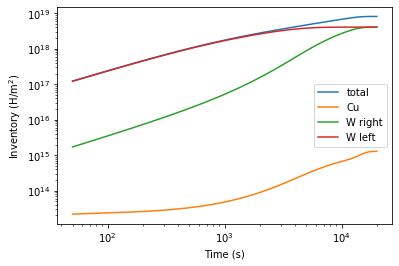

In [10]:
import matplotlib.pyplot as plt

derived_quantities = np.array(output["derived_quantities"][1:])
t = derived_quantities[:, 0]
retention = derived_quantities[:, -1] + derived_quantities[:, -2] + derived_quantities[:, -3]
plt.plot(t, retention, label="total")
plt.plot(t, derived_quantities[:, -1], label="Cu")
plt.plot(t, derived_quantities[:, -2], label="W right")
plt.plot(t, derived_quantities[:, -3], label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")
plt.show()

### 3.2 Particle fluxes

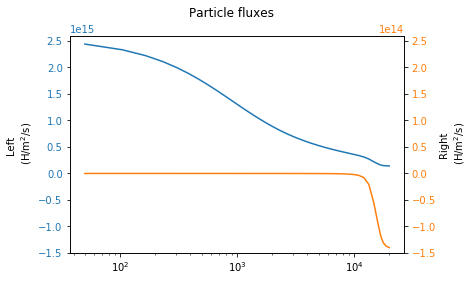

In [11]:
flux_left = derived_quantities[:, 1]
flux_right = derived_quantities[:, 2]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1.5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-1.5e14, 2.6e14)

plt.show()

### 3.3 Trap profiles

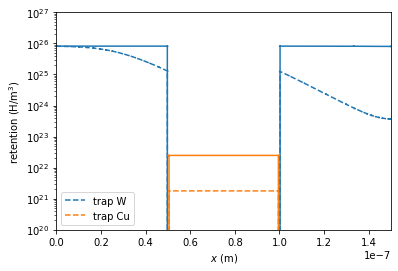

In [12]:
trap_W_1 = np.genfromtxt(folder + '/1_2000.0s.txt')
trap_W_2 = np.genfromtxt(folder + '/1_17000.0s.txt')
trap_cu_1 = np.genfromtxt(folder + '/2_2000.0s.txt')
trap_cu_2 = np.genfromtxt(folder + '/2_17000.0s.txt')

plt.xlim(0, 1.5e-7)
plt.ylim(bottom=1e20, top=1e27)
plt.plot(trap_W_1[:, 0], trap_W_1[:, 1], label="trap W", color="tab:blue", linestyle='--')
plt.plot(trap_cu_1[:, 0], trap_cu_1[:, 1], label="trap Cu", color="tab:orange", linestyle='--')
plt.plot(trap_W_2[:, 0], trap_W_2[:, 1], color="tab:blue")
plt.plot(trap_cu_2[:, 0], trap_cu_2[:, 1], color="tab:orange")
plt.legend()
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("retention (H/m$^3$)")
plt.show()

### 3.4 Solute profiles

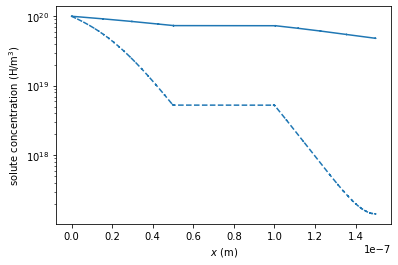

In [13]:
solute_1 = np.genfromtxt(folder + '/solute_2000.0s.txt')
solute_2 = np.genfromtxt(folder + '/solute_17000.0s.txt')

plt.plot(solute_1[:, 0], solute_1[:, 1], linestyle="--")
plt.plot(solute_2[:, 0], solute_2[:, 1], color="tab:blue")
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.show()


## 4.  Conservation of chemical potential at interfaces
Note how the solute concentration is continuous across interfaces.

A more relevant interface model includes conservation of chemical potential across the interfaces.
This can be done with FESTIM by simply providing the **solubility** parameters for the materials.

More details can be found in [Delaporte-Mathurin _et al_ (Nuclear Fusion, 2021)](https://iopscience.iop.org/article/10.1088/1741-4326/abd95f).

In [14]:
# Add the solubility to the materials
parameters["materials"][0]["S_0"] = 1.87e24
parameters["materials"][0]["E_S"] = 1.04
parameters["materials"][1]["S_0"] = 3.14e24
parameters["materials"][1]["E_S"] = 0.57
parameters["materials"][2]["S_0"] = 1.87e24
parameters["materials"][2]["E_S"] = 1.04

# tolerance is increased for better convergence
parameters["solving_parameters"]["newton_solver"]["absolute_tolerance"] = 1e12

output2 = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...


**Have the outputs been impacted ?**

It appears the inventories aren't that much affected though the kinetics seem to be a tad slower.

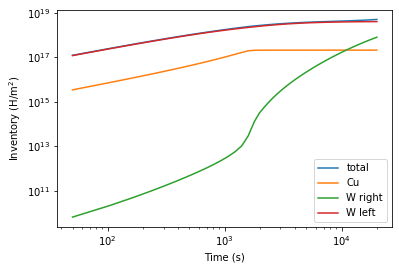

In [15]:
derived_quantities2 = np.array(output2["derived_quantities"][1:])
t = derived_quantities2[:, 0]
retention = derived_quantities2[:, -1] + derived_quantities2[:, -2] + derived_quantities2[:, -3]
plt.plot(t, retention, label="total")
plt.plot(t, derived_quantities2[:, -1], label="Cu")
plt.plot(t, derived_quantities2[:, -2], label="W right")
plt.plot(t, derived_quantities2[:, -3], label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")
plt.show()

When plotting the solute particles concentration profiles, one can now observe the **concentration jumps** at interfaces induced by the difference in solubilities.

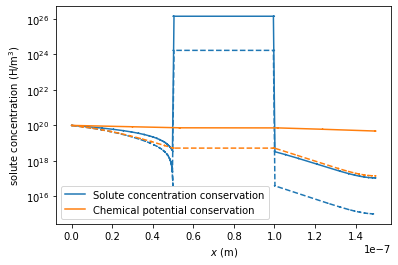

In [16]:
solute_1_chemical_potential = np.genfromtxt(folder + '/solute_2000.0s.txt')
solute_2_chemical_potential = np.genfromtxt(folder + '/solute_17000.0s.txt')

plt.plot(solute_1_chemical_potential[:, 0], solute_1_chemical_potential[:, 1], linestyle="--")
plt.plot(solute_2_chemical_potential[:, 0], solute_2_chemical_potential[:, 1],
         color="tab:blue", label="Solute concentration conservation")

plt.plot(solute_1[:, 0], solute_1[:, 1], linestyle="--")
plt.plot(solute_2[:, 0], solute_2[:, 1], color="tab:orange", label="Chemical potential conservation")

plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.legend()
plt.show()

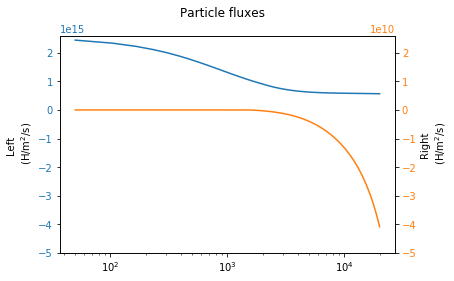

In [17]:
flux_left = derived_quantities2[:, 1]
flux_right = derived_quantities2[:, 2]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-5e10, 2.6e10)
plt.show()